In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras.backend as K

In [6]:
# Define a single data generator with augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

# Training dataset (80% of data)
train_dataset = datagen.flow_from_directory(
    directory= r"C:\Users\Shubhankar\Downloads\archive (3)\Alzheimer_MRI_4_classes_dataset",
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation dataset (20% of data)
valid_dataset = datagen.flow_from_directory(
    directory= r"C:\Users\Shubhankar\Downloads\archive (3)\Alzheimer_MRI_4_classes_dataset",
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


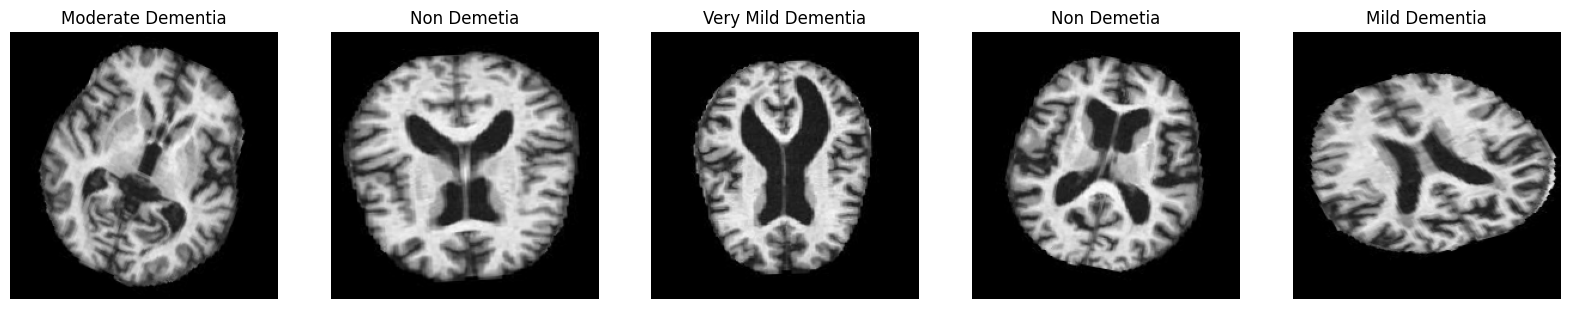

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [8]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [10]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [11]:
# Summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1664)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 81536)          │       326,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │   166,987,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,071,364 (694.55 MB)

 Trainable params: 169,259,268 (645.67 MB)

 Non-trainable params: 12,812,096 (48.87 MB)

In [12]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
import tensorflow as tf

OPT = tf.keras.optimizers.Adam(learning_rate=0.001)  # use 'learning_rate', not 'lr'

METRICS = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    # Add custom F1 score only if defined earlier
    # f1_score
]

model.compile(
    loss='categorical_crossentropy',
    optimizer=OPT,
    metrics=METRICS
)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    verbose=1
)

callback_list = [earlystopping]


In [19]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 235s 6s/step - accuracy: 0.7678 - auc: 0.8049 - loss: 1.2394 - precision: 0.5400 - recall: 0.4815 - val_accuracy: 0.7883 - val_auc: 0.8166 - val_loss: 1.5470 - val_precision: 0.5822 - val_recall: 0.5426
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - accuracy: 0.7840 - auc: 0.8258 - loss: 1.0655 - precision: 0.5791 - recall: 0.4984 - val_accuracy: 0.7996 - val_auc: 0.8346 - val_loss: 1.1006 - val_precision: 0.6176 - val_recall: 0.5215
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 230s 6s/step - accuracy: 0.8013 - auc: 0.8491 - loss: 0.9630 - precision: 0.6206 - recall: 0.5276 - val_accuracy: 0.8108 - val_auc: 0.8595 - val_loss: 0.9027 - val_precision: 0.6572 - val_recall: 0.5082
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 238s 6s/step - accuracy: 0.8058 - auc: 0.8590 - loss: 0.9014 - precision: 0.6325 - recall: 0.5330 - val_accuracy: 0.8184 - val_auc: 0.8701 - val_loss: 0.8414 - val_precision: 0.6874 - val_recall: 0.5020
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━

In [20]:
model.save('dense_alzehimermodel.keras')  # saves entire model


In [21]:
from tensorflow.keras.models import load_model

model = load_model('dense_alzehimermodel.keras')


In [22]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=15,
    callbacks=callback_list  # optional
)

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 246s 6s/step - accuracy: 0.9158 - auc: 0.9710 - loss: 0.3919 - precision: 0.8434 - recall: 0.8143 - val_accuracy: 0.8792 - val_auc: 0.9383 - val_loss: 0.5996 - val_precision: 0.7729 - val_recall: 0.7318
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - accuracy: 0.9205 - auc: 0.9713 - loss: 0.3925 - precision: 0.8518 - recall: 0.8257 - val_accuracy: 0.8815 - val_auc: 0.9432 - val_loss: 0.5704 - val_precision: 0.7770 - val_recall: 0.7381
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - accuracy: 0.9181 - auc: 0.9713 - loss: 0.3924 - precision: 0.8489 - recall: 0.8181 - val_accuracy: 0.8761 - val_auc: 0.9380 - val_loss: 0.6114 - val_precision: 0.7654 - val_recall: 0.7271
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.9213 - auc: 0.9715 - loss: 0.3891 - precision: 0.8522 - recall: 0.8288 - val_accuracy: 0.8800 - val_auc: 0.9419 - val_loss: 0.5787 - val_precision: 0.7710 - val_recall: 0.7396
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━

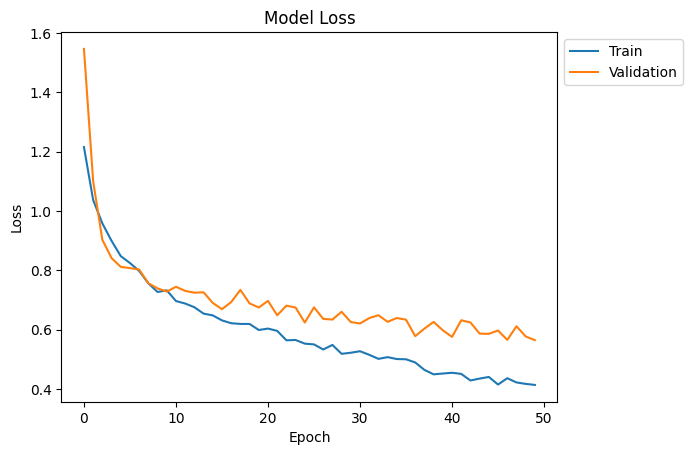

In [23]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

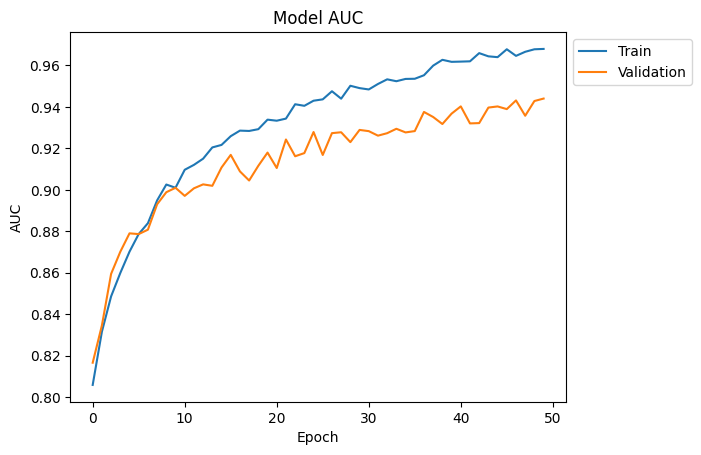

In [24]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [26]:
import tensorflow as tf  # Make sure this is at the top

OPT = tf.keras.optimizers.Adam(learning_rate=0.001)

METRICS = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    # Add this only if you've defined it somewhere
    # f1_score,
]

model.compile(
    loss='categorical_crossentropy',
    optimizer=OPT,
    metrics=METRICS
)


In [28]:
# Test Data 
test_dataset  = test_datagen.flow_from_directory(directory = r"C:\Users\Shubhankar\Downloads\Alzheimers disease dataset\Alzheimers disease dataset\Alzheimer's dataset\OriginalDataset",
                                                 target_size = (224,224),
                                                 class_mode = 'categorical')

Found 6400 images belonging to 4 classes.


In [29]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.8636 - auc: 0.9745 - loss: 0.3705 - precision: 0.8714 - recall: 0.8547


[0.3617885112762451,
 0.9759031534194946,
 0.862500011920929,
 0.8702642321586609,
 0.8542187213897705]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


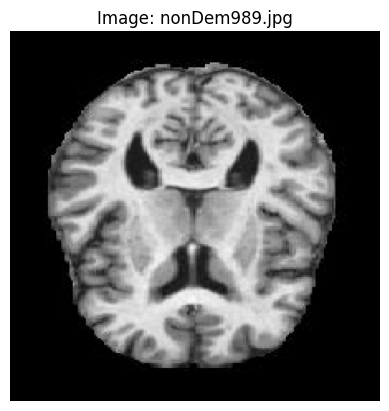

🖼️ Image Name     : nonDem989.jpg
✅ Actual Class   : NonDemented
🔮 Predicted Class: NonDemented
📊 Confidence     : 94.9%


In [ ]:
#for Non demented class
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Image path
img_path = r"C:\Users\Shubhankar\Downloads\Alzheimers disease dataset\Alzheimers disease dataset\Alzheimer's dataset\OriginalDataset\NonDemented\nonDem989.jpg"
actual_class = "NonDemented"
filename = os.path.basename(img_path)

# Load and preprocess image
img = load_img(img_path, target_size=(224, 224, 3))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
predicted_index = np.argmax(pred, axis=1)[0]
predicted_class = idc[predicted_index]
probability = round(np.max(pred) * 100, 2)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {filename}")
plt.show()

# Print result
print(f"🖼️ Image Name     : {filename}")
print(f"✅ Actual Class   : {actual_class}")
print(f"🔮 Predicted Class: {predicted_class}")
print(f"📊 Confidence     : {probability}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


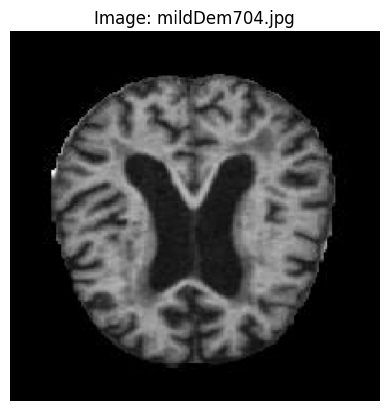

🖼️ Image Name     : mildDem704.jpg
✅ Actual Class   : MildDemented
🔮 Predicted Class: MildDemented
📊 Confidence     : 99.28%


In [34]:
# for mild demented
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Image path
img_path = r"C:\Users\Shubhankar\Downloads\Alzheimers disease dataset\Alzheimers disease dataset\Alzheimer's dataset\OriginalDataset\MildDemented\mildDem704.jpg"
actual_class = "MildDemented"
filename = os.path.basename(img_path)

# Load and preprocess image
img = load_img(img_path, target_size=(224, 224, 3))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
predicted_index = np.argmax(pred, axis=1)[0]
predicted_class = idc[predicted_index]
probability = round(np.max(pred) * 100, 2)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {filename}")
plt.show()

# Print result
print(f"🖼️ Image Name     : {filename}")
print(f"✅ Actual Class   : {actual_class}")
print(f"🔮 Predicted Class: {predicted_class}")
print(f"📊 Confidence     : {probability}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


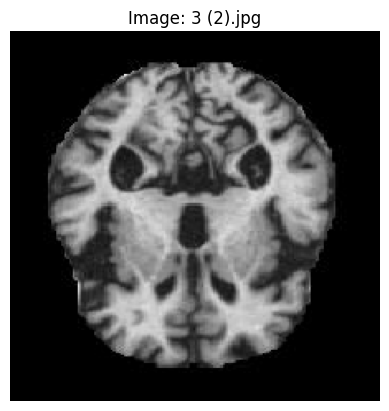

🖼️ Image Name     : 3 (2).jpg
✅ Actual Class   : ModeratedDemented
🔮 Predicted Class: ModerateDemented
📊 Confidence     : 100.0%


In [ ]:
# for moderated demented
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Image path
img_path = r"C:\Users\Shubhankar\Downloads\archive (3)\Alzheimer_MRI_4_classes_dataset\ModerateDemented\3 (2).jpg"
actual_class = "ModeratedDemented"
filename = os.path.basename(img_path)

# Load and preprocess image
img = load_img(img_path, target_size=(224, 224, 3))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
predicted_index = np.argmax(pred, axis=1)[0]
predicted_class = idc[predicted_index]
probability = round(np.max(pred) * 100, 2)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {filename}")
plt.show()

# Print result
print(f"🖼️ Image Name     : {filename}")
print(f"✅ Actual Class   : {actual_class}")
print(f"🔮 Predicted Class: {predicted_class}")
print(f"📊 Confidence     : {probability}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


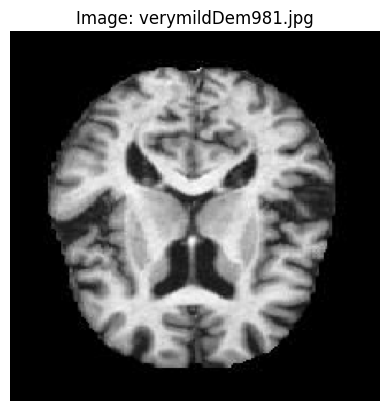

🖼️ Image Name     : verymildDem981.jpg
✅ Actual Class   : veymilddDemented
🔮 Predicted Class: VeryMildDemented
📊 Confidence     : 87.51%


In [38]:
# for very mild demented
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Image path
img_path = r"C:\Users\Shubhankar\Downloads\Alzheimers disease dataset\Alzheimers disease dataset\Alzheimer's dataset\OriginalDataset\VeryMildDemented\verymildDem981.jpg"
actual_class = "veymilddDemented"
filename = os.path.basename(img_path)

# Load and preprocess image
img = load_img(img_path, target_size=(224, 224, 3))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
predicted_index = np.argmax(pred, axis=1)[0]
predicted_class = idc[predicted_index]
probability = round(np.max(pred) * 100, 2)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {filename}")
plt.show()

# Print result
print(f"🖼️ Image Name     : {filename}")
print(f"✅ Actual Class   : {actual_class}")
print(f"🔮 Predicted Class: {predicted_class}")
print(f"📊 Confidence     : {probability}%")


In [41]:
#Confusion Matrix
model.load_weights('dense_alzehimermodel.keras')
true_classes = test_dataset.classes
class_indices = test_dataset.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(test_dataset)
pred_classes = np.argmax(preds, axis=1)

200/200 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step


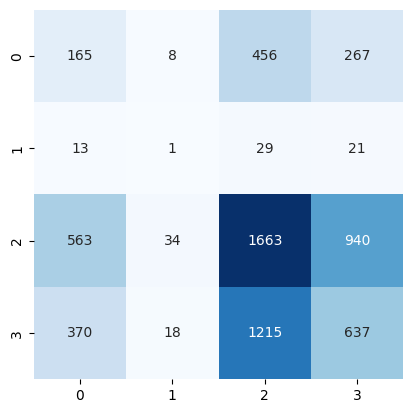

In [43]:
# Get the names of the ten classes
class_names = test_dataset.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, pred_classes)    

plt.show()

In [40]:
model.save('dense_alzehimermodel.keras')